# Import Library

In [77]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, BatchNormalization, 
    Reshape, LSTM, Input, LeakyReLU
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet

# Keras callbacks
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


In [78]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 3

# Image Processing

In [79]:
# pip install torch torchvision torchaudio

In [80]:
# Fungsi Deteksi Objek Menggunakan YOLOv5
def detect_objects_yolo(image_path, model_path='yolov5s'):
    model = torch.hub.load('ultralytics/yolov5', model_path)
    results = model(image_path)
    detections = results.xyxy[0]
    detections = detections.cpu().numpy()
    return detections, results

In [81]:
def preprocess_with_detection_and_processing(image_path, target_size=(224, 224)):
    # Deteksi objek
    detections, _ = detect_objects_yolo(image_path)
    img = cv2.imread(image_path)
    
    if len(detections) > 0:
        # Pilih deteksi dengan confidence tertinggi
        x_min, y_min, x_max, y_max, _, _ = detections[0]
        img = img[int(y_min):int(y_max), int(x_min):int(x_max)]
    
    # Resize ke ukuran target
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    
    # Image Processing: Edge Detection dan Sharpening
    kernel_edge = np.array([[-1, -1, -1],
                            [-1,  8, -1],
                            [-1, -1, -1]])
    edges = cv2.filter2D(img, -1, kernel_edge)
    


    kernel_sharpen = np.array([[0, -1, 0],
                            [-1,  5, -1],
                            [0, -1, 0]])
    processed_img = cv2.filter2D(edges, -1, kernel_sharpen)
    
    return processed_img

### Augmentasi Data dan Normalisasi data

In [82]:
# Custom ImageDataGenerator dengan Preprocessing
class CustomImageDataGeneratorWithProcessing(ImageDataGenerator):
    def preprocessing_function(self, img_path):
        return preprocess_with_detection_and_processing(img_path, target_size=IMG_SIZE)

In [83]:
# Data Generators
train_datagen = CustomImageDataGeneratorWithProcessing(
    rescale=1.0 / 255.0,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4]
)

validation_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)
test_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)

## Mendefinisikan asal folder sumber file berasal

In [84]:
# Directories (Adjust paths as needed)
train_dir = 'dataset/train/'
val_dir = 'dataset/valid/'
test_dir = 'dataset/test/'

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Update NUM_CLASSES based on data
NUM_CLASSES = train_generator.num_classes
labels = train_generator.class_indices.keys()


Found 2721 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 99 images belonging to 3 classes.


In [85]:
labels

dict_keys(['mujahir', 'red_devil', 'sepat'])

# Visualisasi Data

Visualisasi data dengan train:


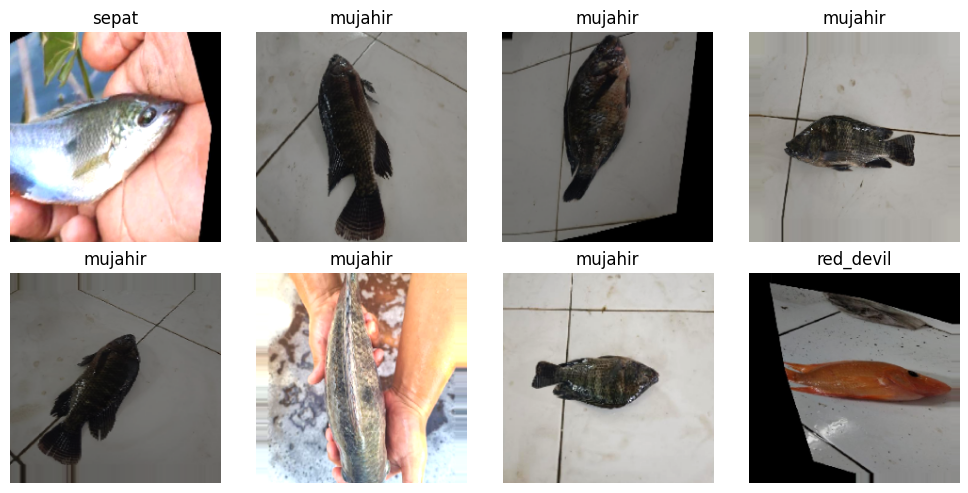

In [86]:
def plot_augmented_images(generator, labels, num_images=8):
    images, labels_batch = next(generator)

    num_images = min(num_images, len(images))  
    labels_decoded = [list(labels)[np.argmax(label)] for label in labels_batch[:num_images]]
    cols = 4  
    rows = (num_images + cols - 1) // cols  
    plt.figure(figsize=(cols * 2.5, rows * 2.5)) 

    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(labels_decoded[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

print("Visualisasi data dengan train:")
plot_augmented_images(train_generator, labels)


### Grid Gambar dari Setiap Kelas

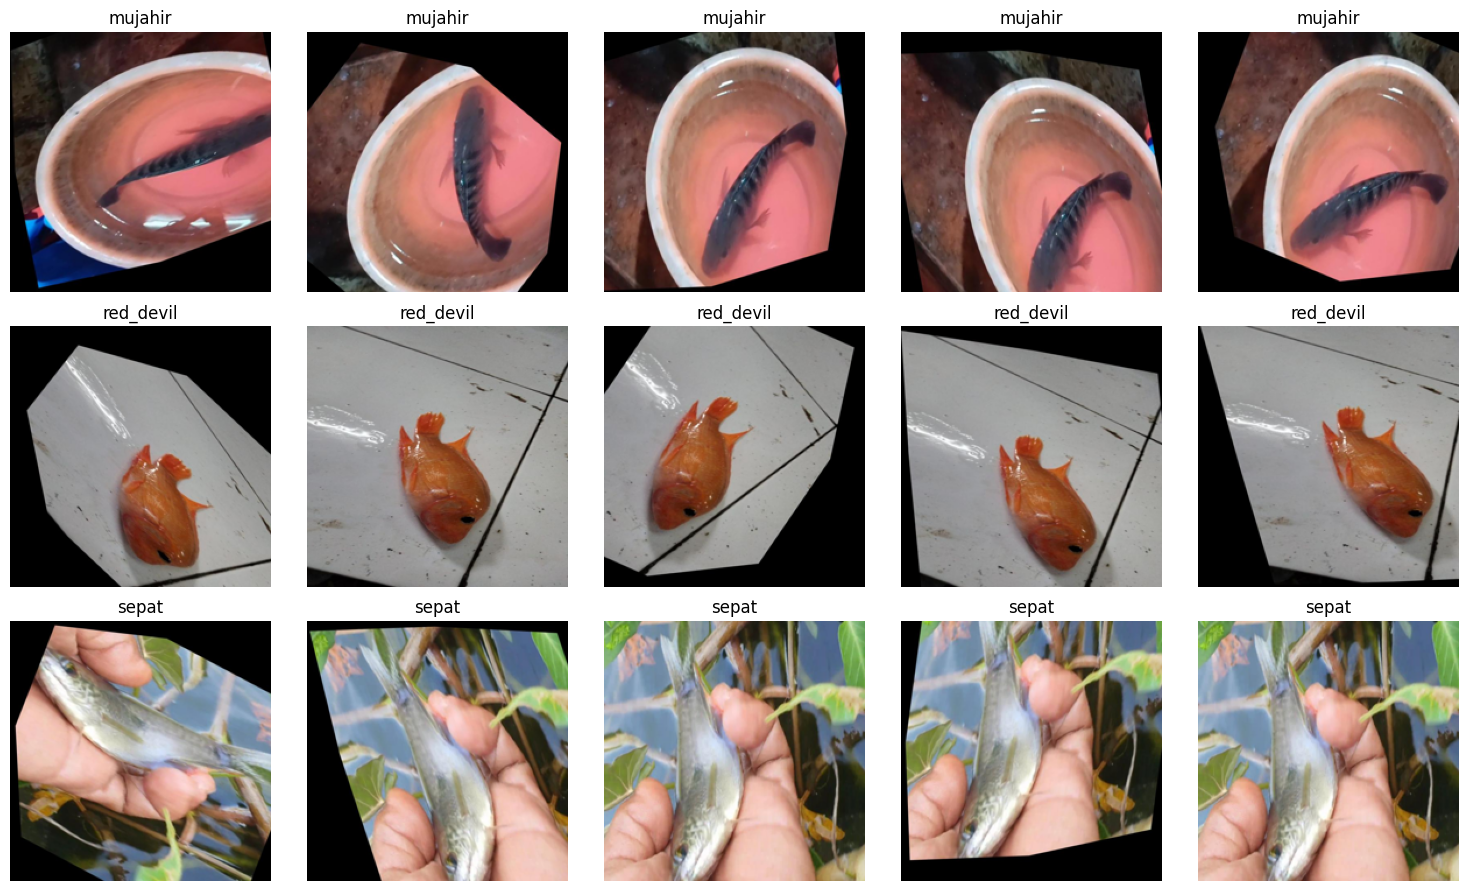

In [87]:
import os
from PIL import Image  
import matplotlib.pyplot as plt

def visualize_samples_per_class(directory, target_size, samples_per_class=5):
    classes = os.listdir(directory)
    plt.figure(figsize=(15, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        images = os.listdir(class_path)[:samples_per_class]
        
        for j, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(target_size) 
            
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_samples_per_class(train_dir, target_size=IMG_SIZE, samples_per_class=5)


C:\Users\M S I\AppData\Local\Temp\ipykernel_19540\3841989112.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette="viridis")


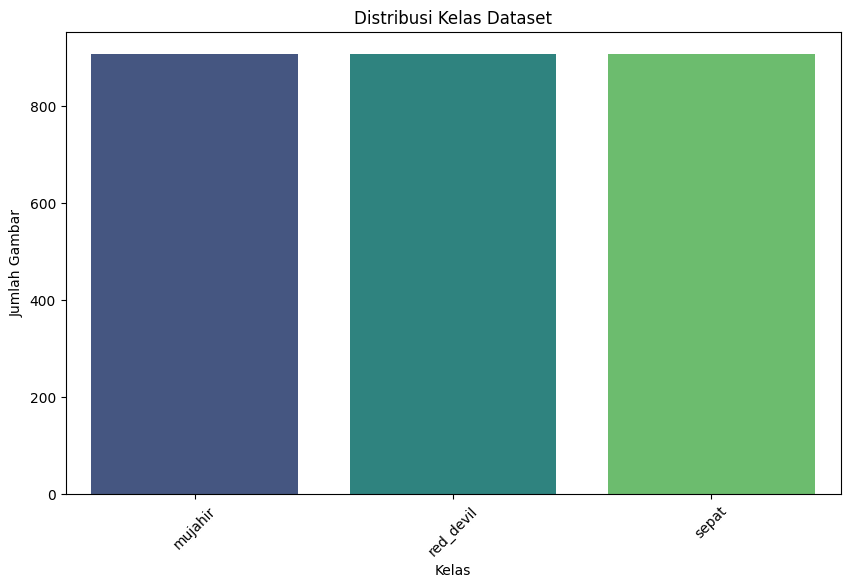

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
import numpy as np

def plot_class_distribution(generator):
    """Visualisasi distribusi kelas"""
    class_counts = Counter(generator.classes) 
    class_names = list(generator.class_indices.keys())
    counts = [class_counts[i] for i in range(len(class_names))]  
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=counts, palette="viridis")
    plt.title("Distribusi Kelas Dataset")
    plt.ylabel("Jumlah Gambar")
    plt.xlabel("Kelas")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_generator)


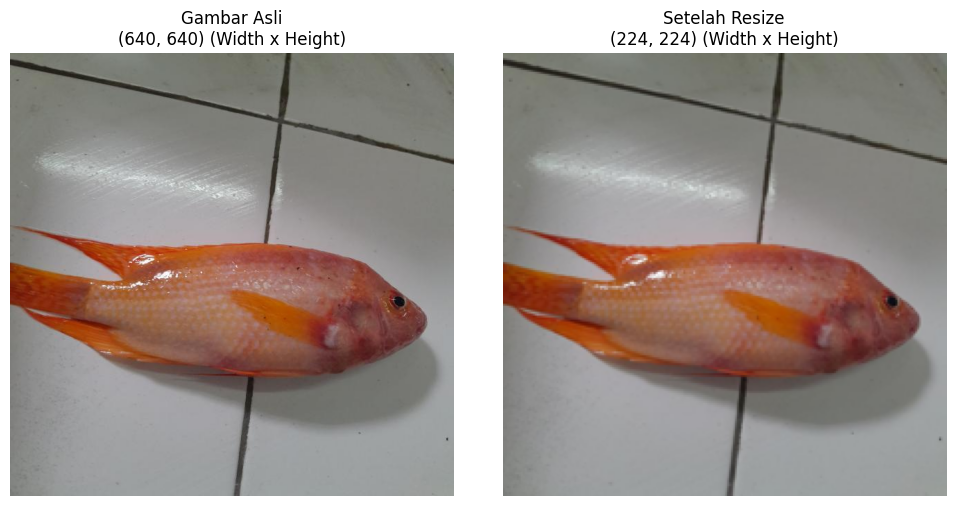

In [89]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_original_and_resized(image_path, target_size):
    try:

        img_original = Image.open(image_path)
        img_original_array = np.array(img_original)

        img_resized = img_original.resize(target_size)
        img_resized_array = np.array(img_resized)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img_original_array)
        plt.title(f"Gambar Asli\n{img_original.size} (Width x Height)")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img_resized_array)
        plt.title(f"Setelah Resize\n{target_size} (Width x Height)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"File tidak ditemukan: {image_path}")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# Contoh penggunaan dengan jalur manual
example_image_path = "dataset/valid/red_devil/Red-Devil-244_jpg.rf.a0570767ba2c29e2686282bc1d07d98d.jpg"
if os.path.exists(example_image_path):
    visualize_original_and_resized(example_image_path, IMG_SIZE)
else:
    print("Jalur gambar tidak ditemukan. Pastikan Anda memasukkan jalur yang benar.")


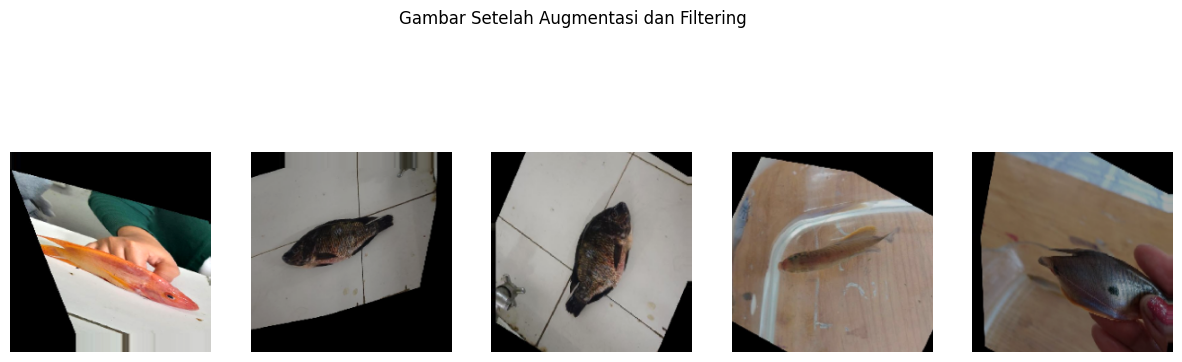

In [90]:
# Fungsi visualisasi
def visualize_augmented_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.suptitle("Gambar Setelah Augmentasi dan Filtering")
    plt.show()

# Visualisasikan gambar
visualize_augmented_images(train_generator, num_images=5)

# Mengubah generator data Python Menjadi dataset TensorFlow

In [91]:
# Define TF Data Generator
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, INPUT_SHAPE)
val_data = tf_data_generator(validation_generator, INPUT_SHAPE)
test_data = tf_data_generator(test_generator, INPUT_SHAPE)


# Model

## ANN

In [92]:
# Model
model = Sequential([
    
    Input(shape=INPUT_SHAPE),

    Flatten(),

    Dense(1024, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),  

    Dense(512, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5), 

    Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5), 

    Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),  

    Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5), 

    Dense(NUM_CLASSES, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [93]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,847,107 (590.69 MB)

 Trainable params: 154,843,139 (590.68 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Tranfer Learning

## Prebuild model

### Build Base Model

In [94]:
# get base models
base_model = MobileNet(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet',
    classes=NUM_CLASSES,
)

# add to top layer

In [95]:
from tensorflow.keras import layers
# Adding custom layers after ResNet50
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="tanh")(x)  

x = layers.Dropout(0.5)(x) 
x = layers.Dense(512, activation="tanh")(x) 

x = layers.Dropout(0.5)(x) 
x = layers.Dense(256, activation="tanh")(x) 

# Output layer
predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,935,363 (18.83 MB)

 Trainable params: 4,913,475 (18.74 MB)

 Non-trainable params: 21,888 (85.50 KB)

### Build Base model

In [96]:
# from efficientnet.tfkeras import EfficientNetB1

# # get base models
# base_model = EfficientNetB1(
#     input_shape=INPUT_SHAPE,
#     include_top=False,
#     weights='noisy-student',
#     classes=NUM_CLASSES,
# )

### Add top network layer to models

In [97]:
# from tensorflow.keras import layers,Sequential
# from tensorflow.keras.models import Model

# #Adding custom layers
# x = base_model.output
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(1024, activation="relu")(x)

# predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# # model.summary()

# # Compile the model
# print('Compiling Model.......')
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# Hyperparameter Tuning

In [98]:
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau

# Hyperparameter Tuning

In [99]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [100]:
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=15,
#     restore_best_weights=True
# )

In [101]:
# Kompilasi model
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [102]:
# Training model
history = model.fit(
    train_generator,
    epochs= 15,
    validation_data=validation_generator,
    callbacks=[reduce_lr],
)

Epoch 1/15


c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 545s 5s/step - accuracy: 0.8547 - loss: 0.3439 - val_accuracy: 0.8683 - val_loss: 0.5512 - learning_rate: 0.1000
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 570s 6s/step - accuracy: 0.9251 - loss: 0.3976 - val_accuracy: 0.8765 - val_loss: 0.3875 - learning_rate: 0.1000
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 535s 6s/step - accuracy: 0.9900 - loss: 0.0447 - val_accuracy: 1.0000 - val_loss: 0.0026 - learning_rate: 0.1000
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 531s 6s/step - accuracy: 0.9757 - loss: 0.1429 - val_accuracy: 0.9877 - val_loss: 0.0439 - learning_rate: 0.1000
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 498s 6s/step - accuracy: 0.9806 - loss: 0.1186 - val_accuracy: 0.9383 - val_loss: 0.2589 - learning_rate: 0.1000
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 511s 6s/step - accuracy: 0.9772 - loss: 0.0840 - val_accuracy: 0.9465 - val_loss: 0.1974 - learning_rate: 0.1000
Epoch 7/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 536s 6s/step - accuracy: 0.9932 - loss: 0.0561 - val_accuracy: 0.98

In [103]:
# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0013
Test Accuracy: 1.00


In [104]:
history.history['loss']

[0.17898789048194885,
 0.3777095377445221,
 0.04788866266608238,
 0.08552096784114838,
 0.14424794912338257,
 0.06105119362473488,
 0.16088521480560303,
 0.17535075545310974,
 0.015164358541369438,
 0.017814112827181816,
 0.013653387315571308,
 0.012989643961191177,
 0.013230674900114536,
 0.012515475042164326,
 0.017733989283442497]

In [105]:
history.history['accuracy']

[0.9364204406738281,
 0.9228224754333496,
 0.9897096753120422,
 0.9841969609260559,
 0.9764792323112488,
 0.984564483165741,
 0.9827269315719604,
 0.9772142767906189,
 0.9955898523330688,
 0.996692419052124,
 0.9970598816871643,
 0.9977949261665344,
 0.9977949261665344,
 0.9981624484062195,
 0.9959573745727539]

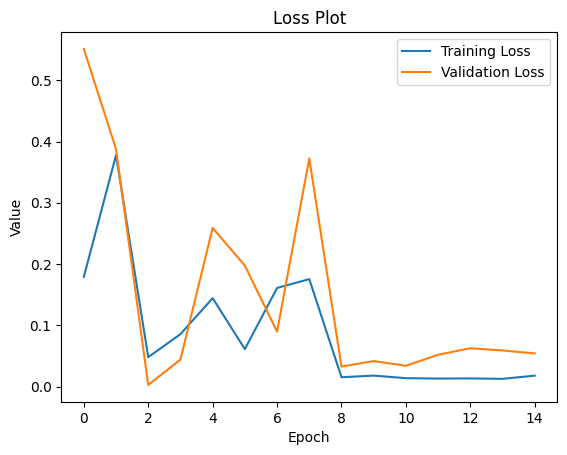

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

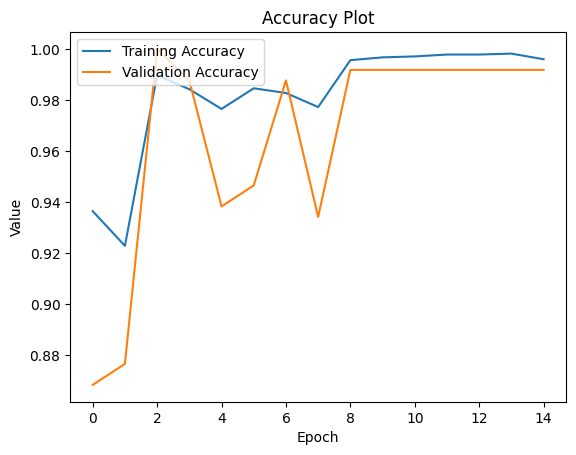

In [107]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Save Model

In [108]:
model.save('../model/model_ANN_tanh_object.keras')


# Evaluasi Model

In [109]:
loss, acc = model.evaluate(train_data,steps=len(train_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')   



Accuracy on training data: 0.9989 
Loss on training data: 0.0038 

Accuracy on test data: 1.0000 
Loss on test data: 0.0009 



### Confusion Matriks


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step 


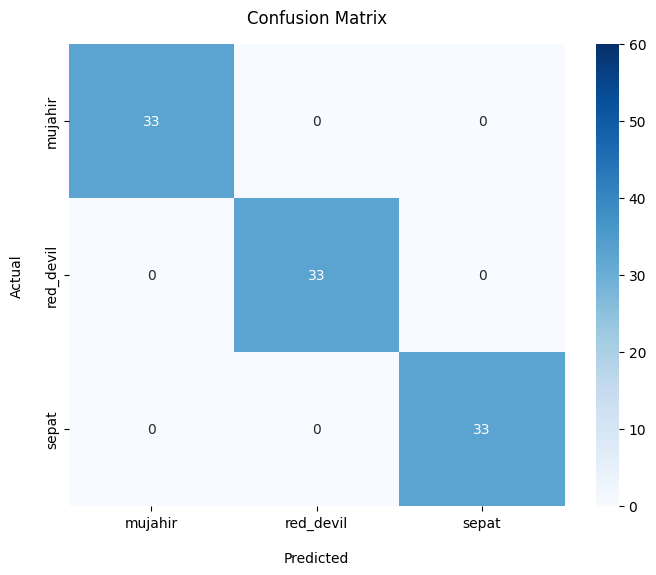

              precision    recall  f1-score   support

     mujahir       1.00      1.00      1.00        33
   red_devil       1.00      1.00      1.00        33
       sepat       1.00      1.00      1.00        33

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



In [110]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

checkpoint = load_model('../model/model_ANN_tanh_object.keras')

predictions = checkpoint.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', vmin=0, vmax=60)
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('Actual', labelpad=15)
plt.title('Confusion Matrix', pad=15)
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


misclassified_indices = np.where(true_classes != predicted_classes)[0]

for idx in misclassified_indices:

    img_path = train_generator.filepaths[idx]
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[predicted_classes[idx]]
    
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()


In [111]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image

# checkpoint = load_model('../model/model_ANN_tanh_object.keras')

# predictions = checkpoint.predict(validation_generator)
# predicted_classes = np.argmax(predictions, axis=1)
# true_classes = validation_generator.classes
# class_labels = list(validation_generator.class_indices.keys())
# confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', vmin=0, vmax=60)
# plt.xlabel('Predicted', labelpad=15)
# plt.ylabel('Actual', labelpad=15)
# plt.title('Confusion Matrix', pad=15)
# plt.show()

# report = classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)


# misclassified_indices = np.where(true_classes != predicted_classes)[0]

# for idx in misclassified_indices:

#     img_path = train_generator.filepaths[idx]
#     true_label = class_labels[true_classes[idx]]
#     pred_label = class_labels[predicted_classes[idx]]
    
#     img = image.load_img(img_path, target_size=(224, 224))
#     plt.imshow(img)
#     plt.title(f"True: {true_label}, Pred: {pred_label}")
#     plt.axis('off')
#     plt.show()


# Pengujuian Model

### Pengujian model dengan data Test


Predictions for class: mujahir
Processing dataset/test/mujahir\1_mp4-0012_jpg.rf.af408cddf66ccba558575e67d654671a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Processing dataset/test/mujahir\3_mp4-0001_jpg.rf.78c9387cea52f16b363b97e29b2224b4.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Processing dataset/test/mujahir\3_mp4-0007_jpg.rf.bad24d31e5fd7ac75000cc3bfa89e488.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing dataset/test/mujahir\3_mp4-0009_jpg.rf.7a6de95452636bd2a742b23d4faf81cd.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/mujahir\5_mp4-0015_jpg.rf.09ab1aaf6b49190b804d1e3d04cbcbc0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Processing dataset/test/mujahir\6_mp4-0000_jpg.rf.977683a3c9107b8fb33a5b971cbebd3b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Processing dataset/test/mujahir\6_mp4-0010_jpg.rf.0d2f29000f8d072d3f12176aa3aa6ef0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing dataset/test/mujahir\6_mp4-0013_jpg.rf.5e66c2d053fe7b1484bd8

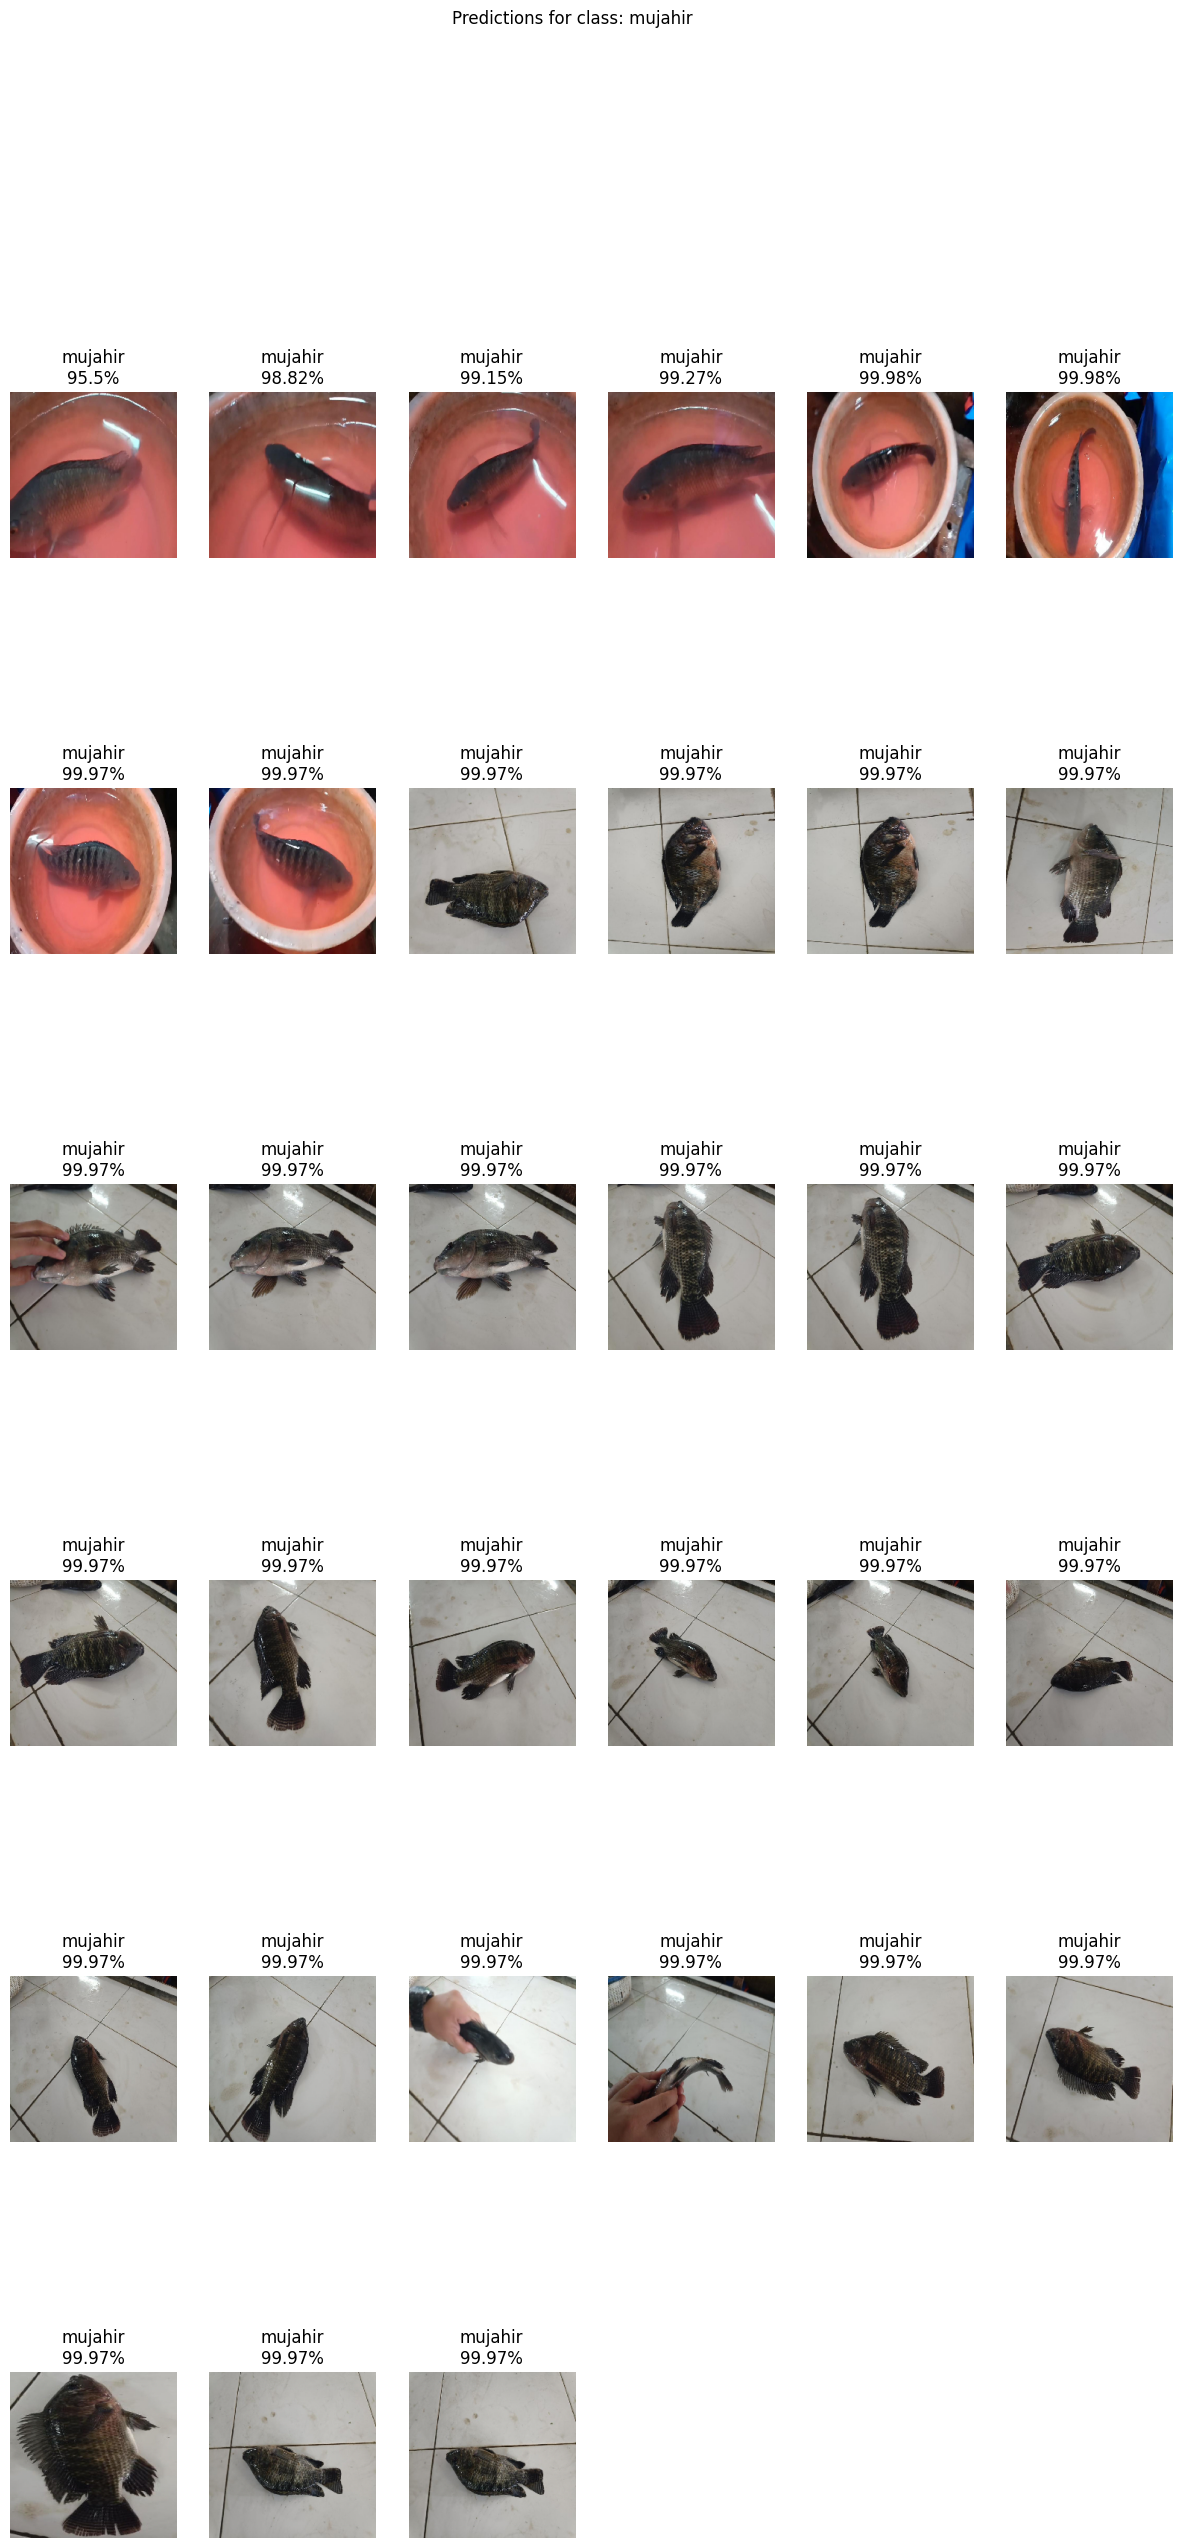


Predictions for class: red_devil
Processing dataset/test/red_devil\Red-Devil-101_png_jpg.rf.d9ed07b6e68c3e93176715b0010a3e33.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processing dataset/test/red_devil\Red-Devil-104_png_jpg.rf.f98dbbec37a56d0a59d7e05f5344b89b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Processing dataset/test/red_devil\Red-Devil-105_png_jpg.rf.b1efa865a6a211728f411c07d75584a5.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
Processing dataset/test/red_devil\Red-Devil-109_png_jpg.rf.7d9224c65e66461b159bda0982f45d7f.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Processing dataset/test/red_devil\Red-Devil-122_png_jpg.rf.aa35b61ed0b16c3834001f5945a8fc38.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Processing dataset/test/red_devil\Red-Devil-132_png_jpg.rf.ae8fcd7bc96bbea6375168be5bcc857c.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Processing dataset/test/red_devil\Red-Devil-153-_jpg.rf.e300eec181f3255f1b7e705612f6c111.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processi

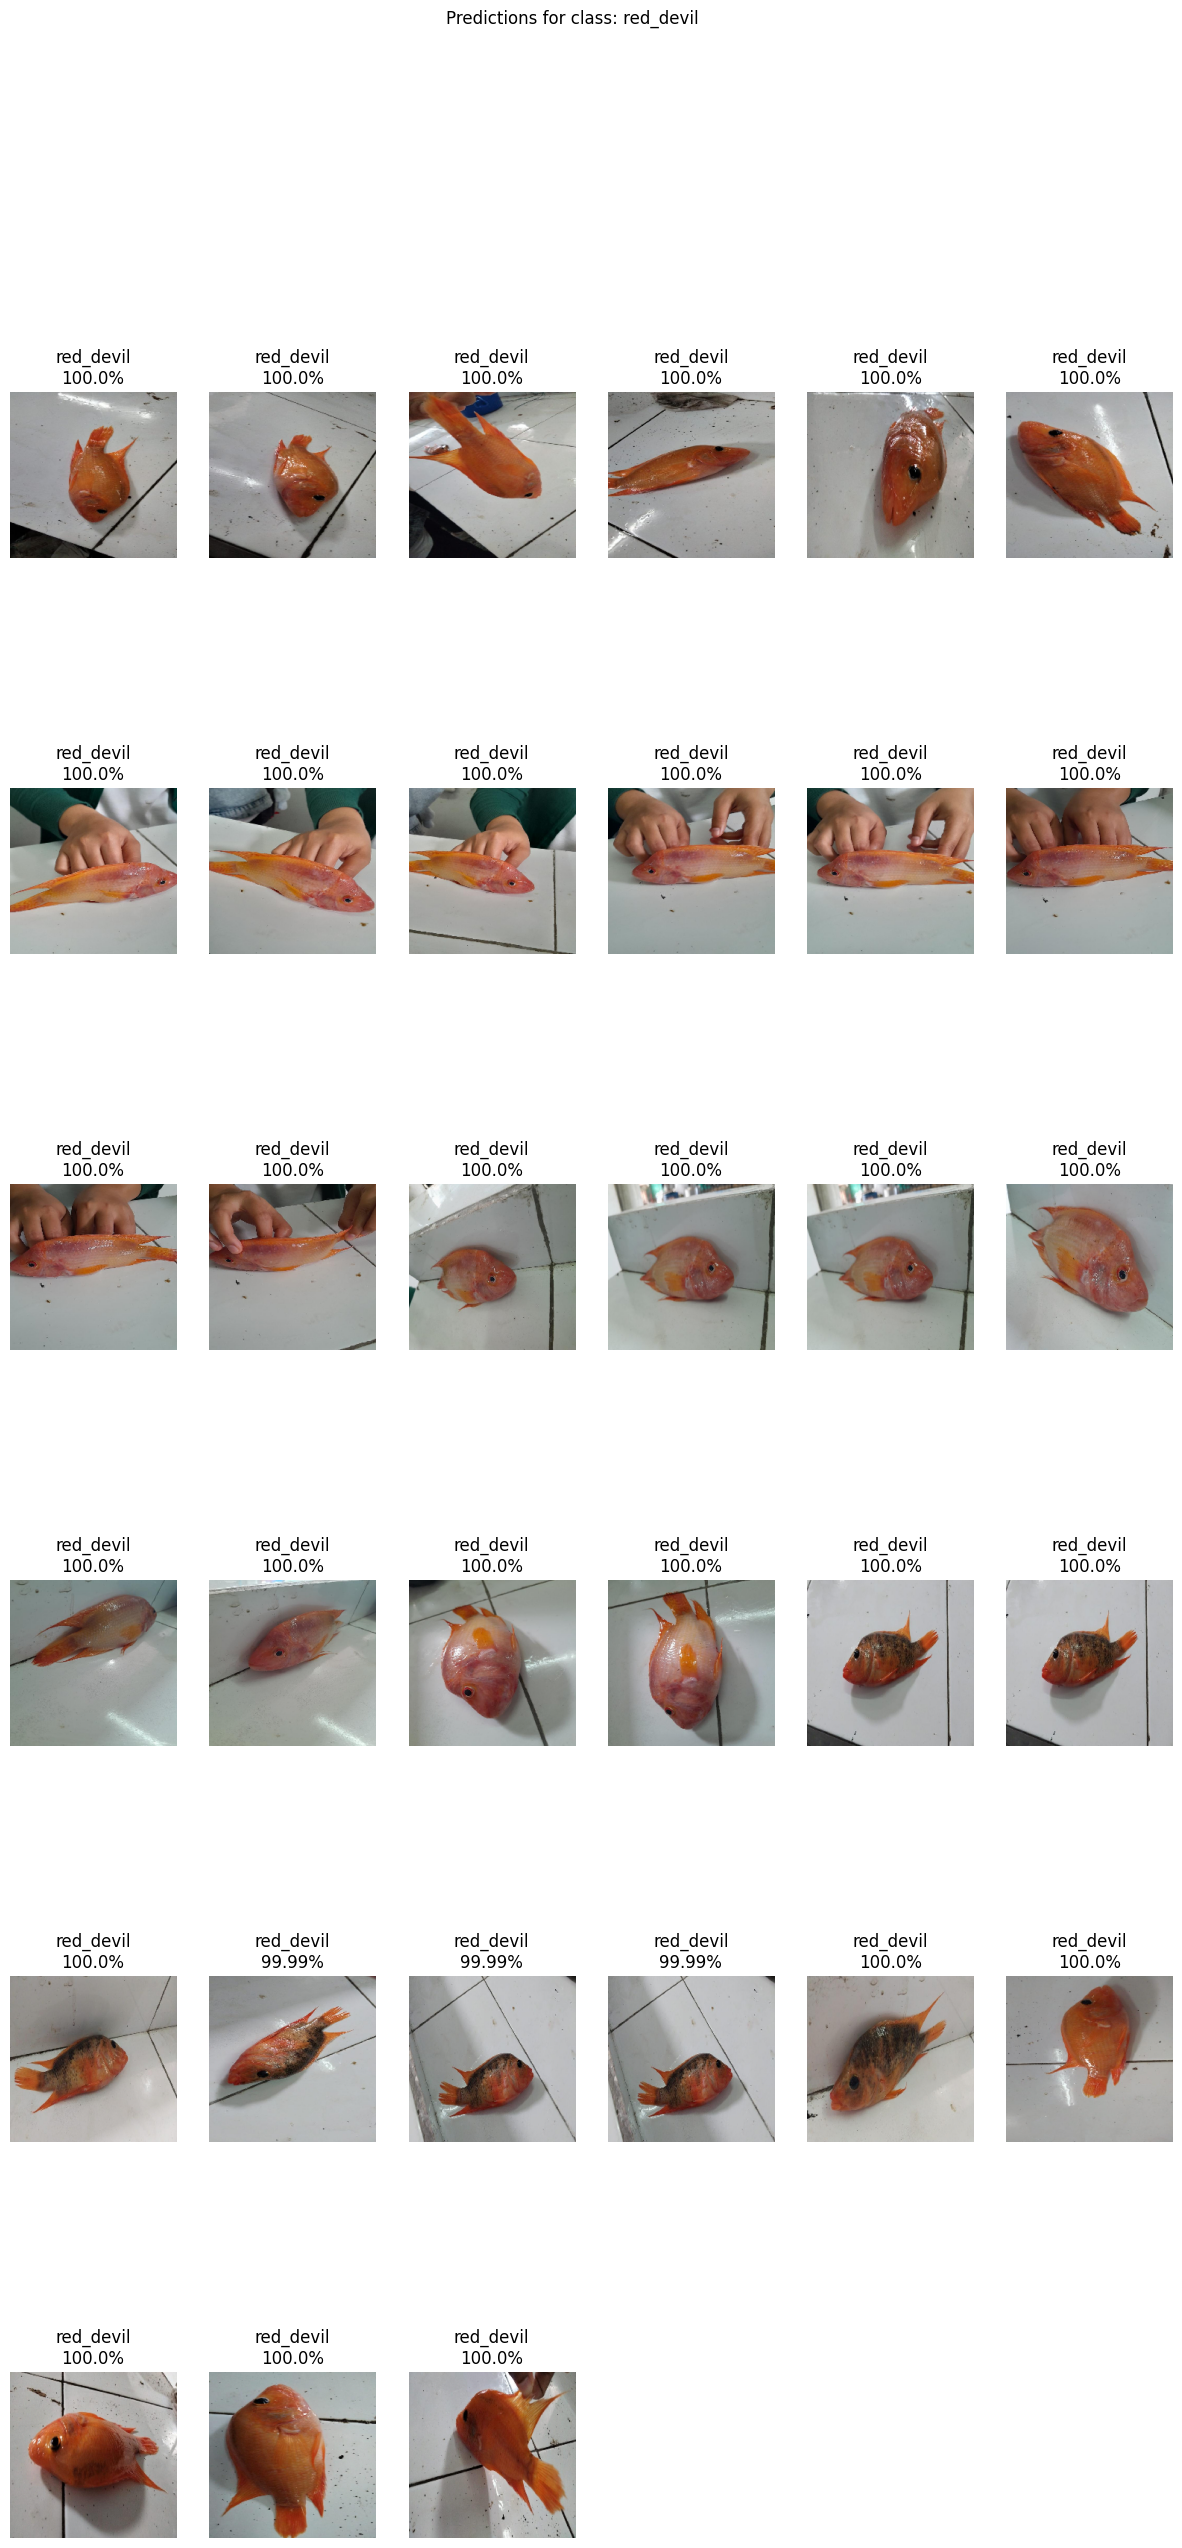


Predictions for class: sepat
Processing dataset/test/sepat\Sepat-104_png_jpg.rf.c8efe00703ee19d384763c8a05f1b4f6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Processing dataset/test/sepat\Sepat-105_png_jpg.rf.e07125ea47295be33fcbe35134c37fc6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing dataset/test/sepat\Sepat-115_png_jpg.rf.10ef20970ea1c9e1857d1192fa523831.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processing dataset/test/sepat\Sepat-117_png_jpg.rf.dfe4e7f8212150cc64d5ddef0e09aaf1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Processing dataset/test/sepat\Sepat-15_png_jpg.rf.29fb2d9e7813596912e320f4e4017b8a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/sepat\Sepat-16_png_jpg.rf.eeed7dcbc9bb558bc6056c1e9964eb61.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Processing dataset/test/sepat\Sepat-176_jpg.rf.b6caed48284f4995afd08e63b1ee04ce.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/sepat\Sepat-184_jpg.rf.ccc8af4b661e42903d254dc517

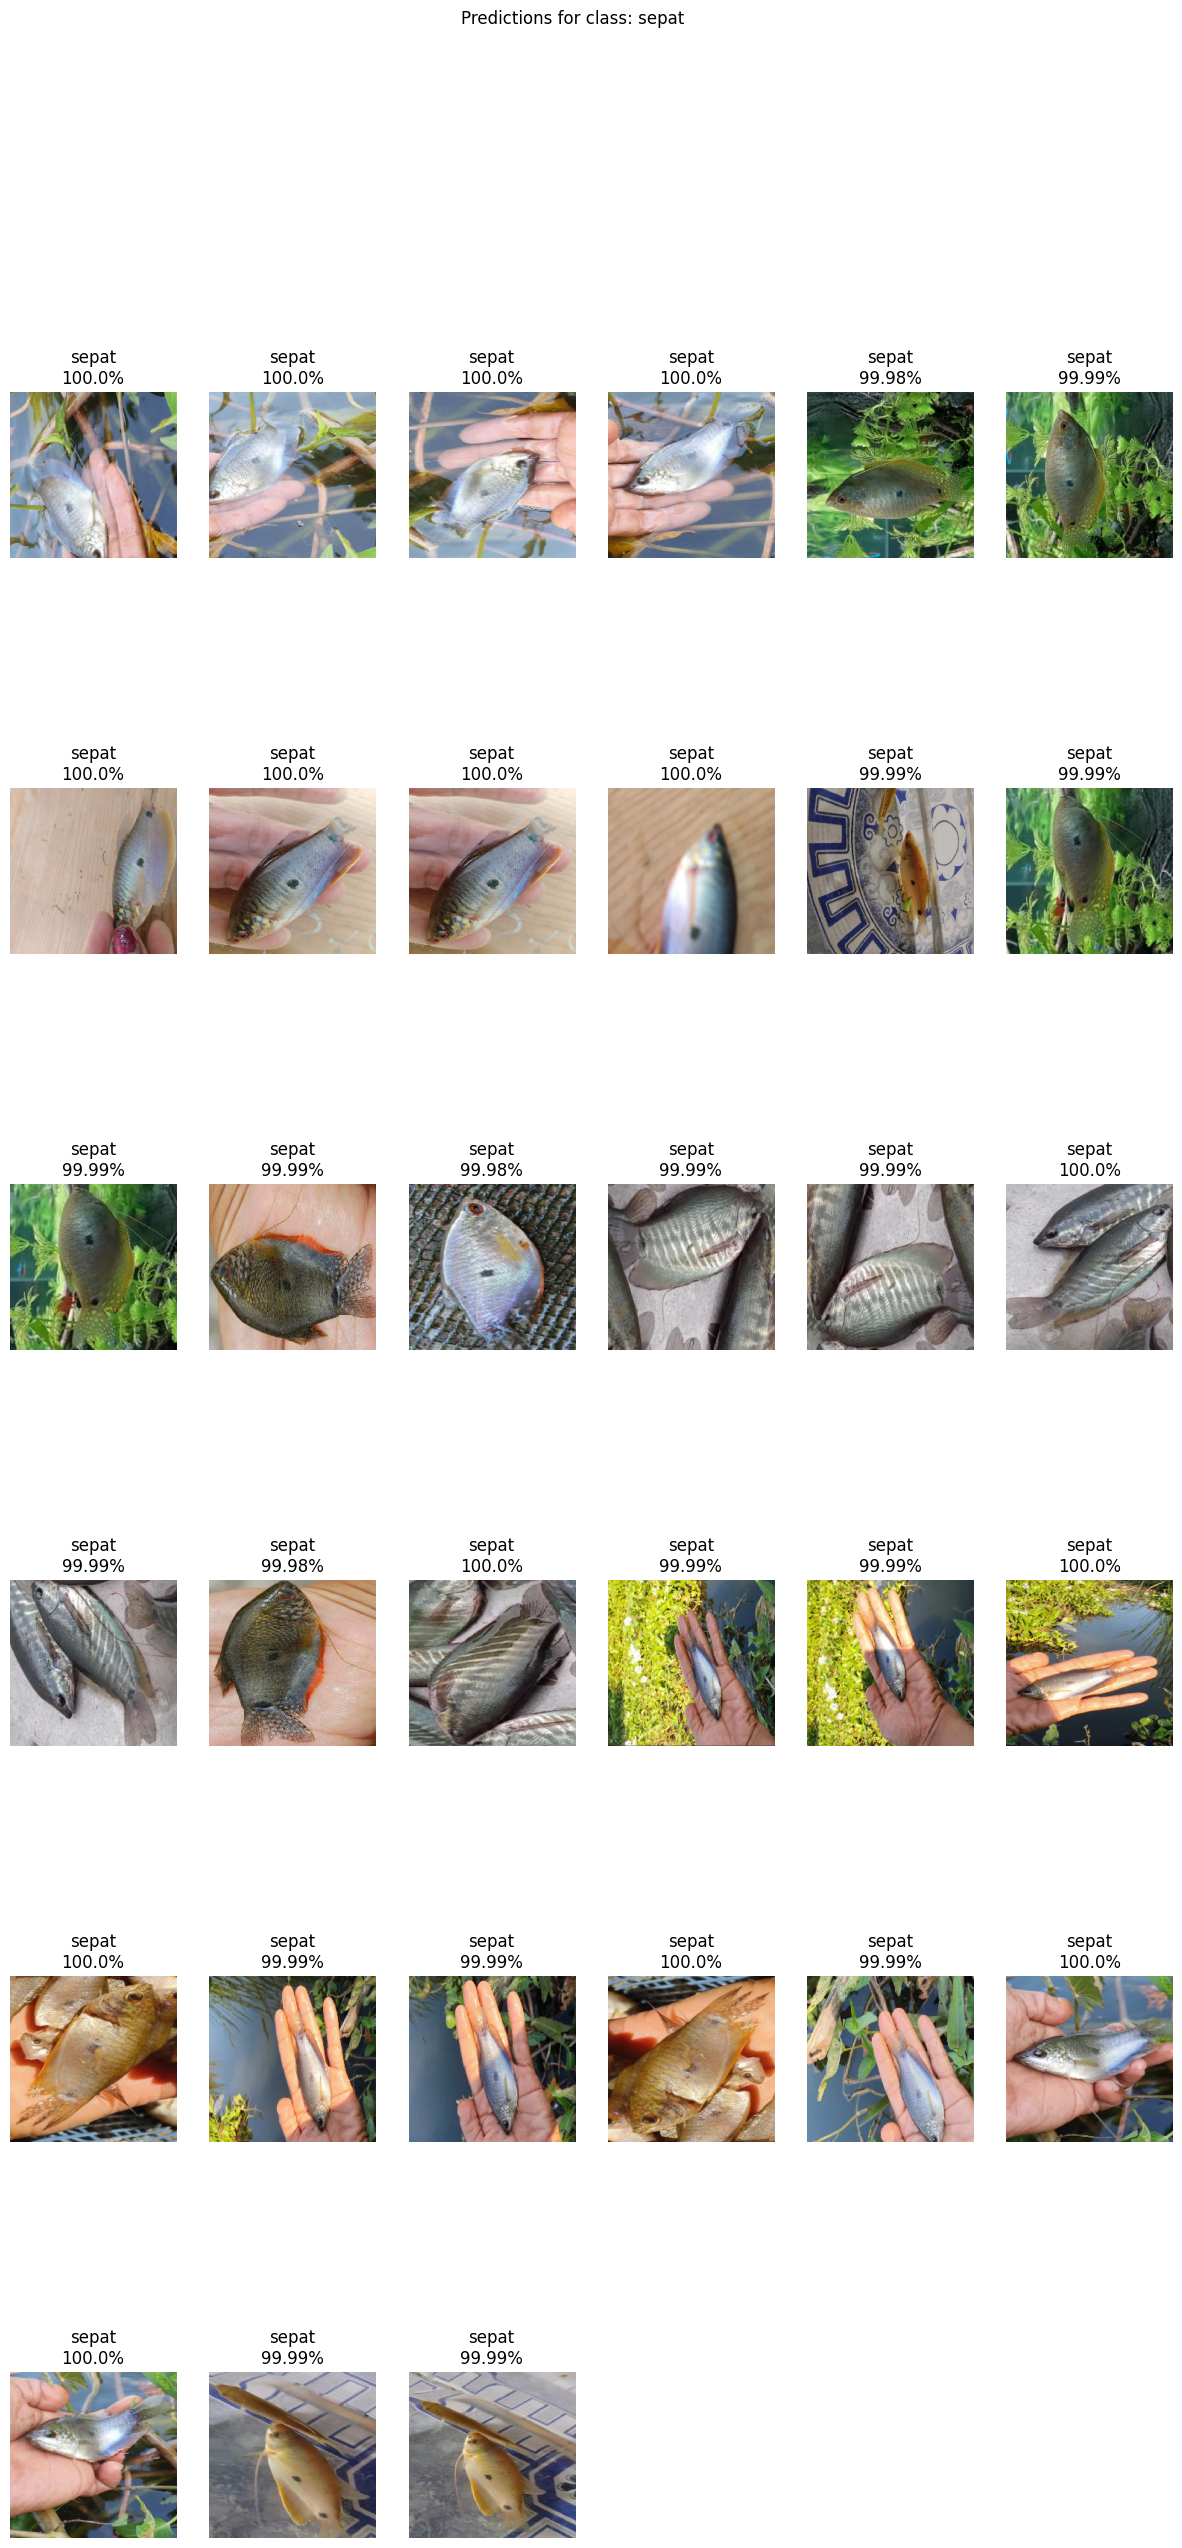

In [112]:
# Load model
model_path = '../model/model_ANN_tanh_object.keras' 
loaded_model = load_model(model_path)

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=IMG_SIZE)  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    probability = np.max(predictions[0]) 

    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    return img, label, round(probability * 100, 2)

def predict_images_from_class(class_folder, model):
    images = []
    labels = []
    probabilities = []

    # Ambil semua gambar dari folder kelas tertentu
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
            print(f"Processing {img_path}...")
            img, label, probability = predict_image(img_path, model)
            images.append(img)
            labels.append(label)
            probabilities.append(probability)

    return images, labels, probabilities

dataset_path = 'dataset/test/'

classes = ['mujahir', 'red_devil', 'sepat']

# Prediksi gambar dari setiap kelas
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    print(f"\nPredictions for class: {class_name}")
    images, labels, probabilities = predict_images_from_class(class_folder, loaded_model)
    max_images_per_row = 6
    num_rows = (len(images) + max_images_per_row - 1) // max_images_per_row 

    plt.figure(figsize=(15, 5 * num_rows))
    for i in range(len(images)):
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"{labels[i]}\n{probabilities[i]}%")
    
    plt.suptitle(f"Predictions for class: {class_name}")
    plt.show()

In [113]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)

model_path = '../model/model_ANN_tanh_object.keras' 
loaded_model = load_model(model_path)

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_SIZE))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    
    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    # Tampilkan gambar
    plt.figure(figsize=(10, 5))
    
    # Subplot untuk gambar
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}")

    # Subplot untuk bar chart probabilitas
    plt.subplot(1, 2, 2)
    plt.bar(labels, predictions[0] * 100)
    plt.title('Class Probabilities')
    plt.ylabel('Probability (%)')
    plt.xticks(rotation=45)
    
    # Tambahkan nilai probabilitas di atas bar
    for i, prob in enumerate(predictions[0]):
        plt.text(i, prob * 100, f'{prob * 100:.2f}%', 
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print hasil prediksi
    print("\nPrediction probabilities:")
    for label, prob in zip(labels, predictions[0]):
        print(f"{label}: {prob * 100:.2f}%")

# Path ke gambar
# img_path = 'new_data/Ikan-Sepat.jpg'
# img_path = 'new_data/ikan-red-devil-3137882226 .jpg'
# img_path = 'new_data/ikan-mujair1.jpg'
# img_path = 'new_data/6n (238).jpg'
# img_path = 'new_data/Red-devil2.jpg'
# img_path = 'new_data/devil.jpg'


# Prediksi gambar
predict_image(img_path, loaded_model)

NameError: name 'img_path' is not defined

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


# Path ke model Anda
model_path = '../model/model_ANN_tanh_object.keras'
loaded_model = load_model(model_path)

labels = ['mujahir', 'red_devil', 'sepat'] 

# Fungsi untuk melakukan prediksi
def predict_frame(frame, model):

    resized_frame = cv2.resize(frame, (224, 224)) 
    normalized_frame = resized_frame / 255.0  
    input_frame = np.expand_dims(normalized_frame, axis=0) 

    # Prediksi menggunakan model
    predictions = model.predict(input_frame)
    predicted_label = labels[np.argmax(predictions)]
    confidence = np.max(predictions) * 100 
    return predicted_label, confidence

# Inisialisasi kamera
cap = cv2.VideoCapture(0) 

if not cap.isOpened():
    print("Kamera tidak dapat diakses!")
    exit()

print("Menyalakan kamera. Tekan 'q' untuk keluar.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Tidak dapat membaca frame dari kamera.")
        break

    # Lakukan prediksi pada frame saat ini
    predicted_label, confidence = predict_frame(frame, loaded_model)
    # Tampilkan prediksi di frame
    text = f"{predicted_label}: {confidence:.2f}%"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Tampilkan frame
    cv2.imshow("Real-time Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Menyalakan kamera. Tekan 'q' untuk keluar.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━